
# Computer Vision Model Comparison Notebook
##  Introduction
The purpose of this notebook is to compare different computer vision models and find the best matching one to classify dog breeds using a picture. This will be done by comparing some Computer Vision classifiers and model optimization techniques.

# Setup
1. Import necessary libraries, including those for data processing and visualization.
2. Load the data to be used for model comparison.
Split the data into training and testing sets.

# Model Selection
1. Define the models to be compared (e.g. ResNet, VGG, Inception, etc.).
2. Train each model on the training set and evaluate their performance on the testing set using accuracy.
3. Generate visualizations (e.g. bar charts, confusion matrices) to compare the performance of each model.

# Model Optimization
1. Based on the results of model selection, choose the best model.
2. Fine-tune the chosen model by adjusting its hyperparameters and/or adding additional layers.
3. Evaluate the optimized model on the testing set.

# Conclusion
1. Summarize the results of the model comparison and optimization.
2. Save the final model for deployment.

## Set-up

Import necessary libraries, including those for data processing and visualization.

### Colab GPU Dependencies

Installation of necessary packages to allow GPU processing.
We also need the python library "tensorflow_addons" which allows us to easily import the "stanford dogs" dataset.

In [1]:
! pip install vit_keras tensorflow_addons
# Install this package to use Colab's GPU for training
! apt install --allow-change-held-packages libcudnn8=8.4.1.50-1+cuda11.6

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19581 sha256=d23aa1306142062572f1d2d745f698974e84134d831433e2a0c6ffdad4af778b
  Stored in directory: /root/.cache/pip/wheels/19/09/72/3eb74d236bb48bd0f3c6c3c83e4e0c5bbfcbcad7c6c3539db8
Successfully built validators
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 19 not upgraded.
Need to get 420 MB of ar

## Python dependencies

Importing the necessary machine learning & data processing packages.
We also will be using "os" and "pathlib" to access the saved model file easily.

In [2]:
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import tensorflow_datasets as tfds
import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Model

import vit_keras.vit

Let's see if we have a GPU available on this machine.

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Perfect !
Now let's start coding.

This code loads a dataset from TensorFlow Datasets (TFDS) and preprocesses it to be used with a deep learning model. Specifically, it loads the Stanford Dogs dataset, which contains images of dogs paired with 4 different features, and prepares it for use in a classification model.

The dataset contains 20,580 images, 120 classes (breeds), each piece of data has 4 different features : image, filename, label and bbox.

*create_dataset : map function allows the preprocessing functions to be applied to the data in parallel, which can speed up the preprocessing step. The shuffle function shuffles the data with a buffer size of 1000 (for randomness), and the prefetch function prefetches one batch of data to reduce the time it takes to load the data during training. The batch function batches the data and the buffer size is set to 1000, which means that the model will sample 1000 elements from the shuffled dataset buffer to create each batch.*

In [4]:
# import the dataset and its info
ds_both, ds_info = tfds.load("stanford_dogs", as_supervised=False, with_info=True)

class_names = ds_info.features['label'].names
n_classes = len(class_names)

# separate it into train and test datasets
ds_train, ds_test = ds_both["train"], ds_both["test"]

# resizes the image to 256x256, converts it to a float32 data type
# and formats (img, filename, label, bbox) => (img : tensor, label : int)
def preprocess(img, label):
    img = tf.image.resize(img, [256, 256])
    img = tf.cast(img, dtype=tf.float32)
    
    return img, int(label)

# applies the preprocessing functions to the images and labels, shuffles the data,
# batches it for training, and prefetches it for optimal performance
def create_dataset(model_preprocess, ds, batch_size=32, buffer_size=1000):
    ds = ds.map(lambda x: (x['image'], x['label']), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(lambda x, y: (model_preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.shuffle(buffer_size, seed=42)
    ds = ds.batch(batch_size)
    return ds.prefetch(1)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteGJ2VV8/stanford_dogs-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteGJ2VV8/stanford_dogs-test.tfrecord*...:   0%…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


Visualization of some examples.

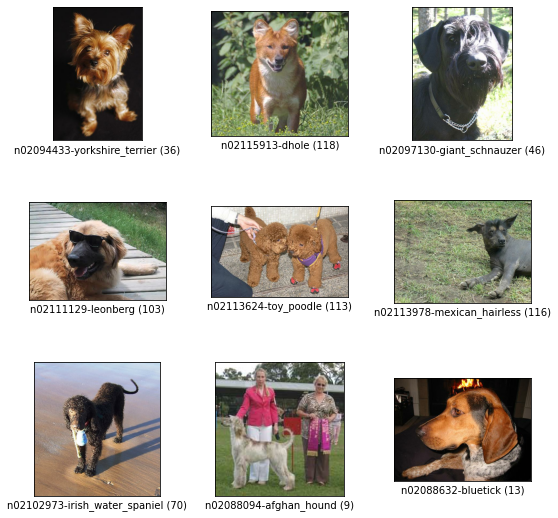

In [ ]:
def visualize_examples():
  tfds.visualization.show_examples(ds_train, ds_info)
visualize_examples()

Creation of generic code to instantiate a keras model.

In [15]:
# frees some RAM ater a training
def restart():
  # kills every instance of TF models
  keras.backend.clear_session()

  # deterministic training
  tf.random.set_seed(69)
  np.random.seed(69)

# instantiates datasets and preprocesses them according to the model
def create_datasets(preprocess):
  train_set = create_dataset(preprocess, ds_train, 128) 
  valid_set = create_dataset(preprocess, ds_test, 128)
  return train_set, valid_set

# creates a data augmentation layer that we will inject in our model
def create_data_augmentation_layer():
  return tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomTranslation((-0.1, 0.1), (-0.1, 0.1), fill_mode="reflect"),
    layers.RandomZoom((-0.1, 0.1), (-0.1, 0.1), fill_mode="reflect"),
    layers.RandomRotation(0.1),
    layers.RandomBrightness(0.1, value_range=(0.0, 1.0)),
    layers.RandomContrast(0.11)
  ])

def create_model(structure, vit=False, fine_tune=False, data_augmentation=False, prepro=None):
  # creates a transfer learning model based on pre-trained models in TensorFlow's Keras API
  # we need to change its architecture according to if it's a ViT model or not
  def create_transfer_model(structure, vit=False, fine_tune=False, data_augmentation=False):
    if vit:
      m = structure(
        pretrained=True,
        pretrained_top=False,
        include_top=False,
        image_size=256,
        classes=n_classes
      )
    else:
      m = structure(
        include_top=False,
        input_shape=(256, 256, 3),
        classes=n_classes
      )

    # fine tuning some layers
    for layer in m.layers[100 if fine_tune else 0:]:
            layer.trainable = fine_tune
    
    return m

  # keras model
  transfer_model = create_transfer_model(structure, vit, fine_tune, data_augmentation)

  # Create a new layer on top that corresponds to an input 256x256 pixel RGB image
  inp = tf.keras.layers.Input(shape=(256, 256, 3), name='input')

  # Add a data augmentation layer if needed
  if data_augmentation:
    da_layer = create_data_augmentation_layer()
    x = da_layer(inp)
    x = transfer_model(x)
  else:
    x = transfer_model(inp)

  if not(vit):
    # converts the 2D feature map output of the convolutional layers to a 1D feature vector
    # incompatible with ViT
    x = tf.keras.layers.GlobalAveragePooling2D(name='globalAveragePooling')(x)

  # added to prevent overfitting of the model
  x = tf.keras.layers.Dropout(0.20)(x)
  x = tf.keras.layers.Dense(64,activation='relu')(x)
  x = tf.keras.layers.Dropout(0.20)(x)

  # layer with n_classes neurons, each corresponding to a different class label,
  # with softmax activation function that outputs a probability distribution over the classes
  predictions = tf.keras.layers.Dense(n_classes, activation='softmax')(x)

  model = Model(inputs=inp, outputs=predictions)

  # loss optimizer
  optim = tf.keras.optimizers.Adam()

  # the loss is represented by the Sparse Categorical Cross-Entropy,
  # for this multiclass classification problem
  model.compile(loss="sparse_categorical_crossentropy",
                optimizer=optim,
                metrics=["accuracy"])
  
  return model, transfer_model

Now that we have set up the dataset and the creation of models, we can proceed to the training step. The fit() function requires that we specify the number of epochs to train the model for.

An epoch is a single pass through the entire dataset. During one epoch, the model processes each training example in the dataset once and updates its weights to minimize the loss. One epoch can consist of multiple iterations, which are the number of times the optimizer updates the weights based on the batch of examples that it sees.

Let's start with 5 epochs.

In [16]:
# pre-trained model lists

structures = [
    tf.keras.applications.efficientnet.EfficientNetB7, # 0 - 255 pixel color range
    tf.keras.applications.efficientnet_v2.EfficientNetV2S, # 0 - 255 pixel color range
    tf.keras.applications.inception_resnet_v2.InceptionResNetV2, # -1 - 1 pixel color range
    tf.keras.applications.inception_v3.InceptionV3, # -1 - 1 pixel color range
    tf.keras.applications.mobilenet_v2.MobileNetV2, # -1 - 1 included
    tf.keras.applications.vgg19.VGG19, # -127 - 126 pixel color range
    tf.keras.applications.resnet_v2.ResNet152V2, # -1 - 1 pixel color range
    vit_keras.vit.vit_l32
]

is_vit = [False] * 8
is_vit[7] = True

preprocessing = [
    tf.keras.applications.efficientnet.preprocess_input,
    tf.keras.applications.efficientnet_v2.preprocess_input,
    tf.keras.applications.inception_resnet_v2.preprocess_input,
    tf.keras.applications.inception_v3.preprocess_input,
    tf.keras.applications.mobilenet_v2.preprocess_input,
    tf.keras.applications.vgg19.preprocess_input,
    tf.keras.applications.resnet_v2.preprocess_input,
    vit_keras.vit.preprocess_inputs
]

models_to_test = zip(structures, preprocessing)

In [17]:
def train_model(model, name, epochs=5, save=True):
  # train the model
  start_time = time.time()

  with tf.device('/GPU:0'):
    history_model = model.fit(train_set, epochs=epochs, 
                                          validation_data=valid_set)
  total_time = time.time() - start_time
  # save the trained model structure and weights
  if save:
    model.save(name + "_model_no_augm.h5")
  return history_model, total_time

In [18]:
histories = {}
epochs = 10
restart()

In [ ]:
# sample training (faster)
ds_train = ds_train.take(2048)
ds_test = ds_test.take(2048)

In [ ]:
# trains each model
for i, b in enumerate(models_to_test):
  structure, preprocessing = b
  print("[?] Creating Datasets")
  train_set, valid_set = create_datasets(preprocessing)
  print("[?] Creating Model")
  model, transfer_model = create_model(structure, is_vit[i])
  model_name = transfer_model.name
  print(f"[{model_name}] Training Model")
  histories[model_name] = train_model(model, model_name, epochs, False)
  print(f"[{model_name}] ***** Finished *****")
  restart()

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


[?] Creating Datasets
[?] Creating Model
258076736/258076736 [==============================] - 8s 0us/step
[efficientnetb7] Training Model
Epoch 1/10
16/16 [==============================] - 96s 4s/step - loss: 4.5234 - accuracy: 0.1597 - val_loss: 4.0913 - val_accuracy: 0.4395
Epoch 2/10
16/16 [==============================] - 59s 4s/step - loss: 3.6277 - accuracy: 0.4629 - val_loss: 3.1513 - val_accuracy: 0.5879
Epoch 3/10
16/16 [==============================] - 72s 5s/step - loss: 2.6822 - accuracy: 0.6191 - val_loss: 2.2558 - val_accuracy: 0.7134
Epoch 4/10
16/16 [==============================] - 61s 4s/step - loss: 1.8422 - accuracy: 0.7344 - val_loss: 1.5251 - val_accuracy: 0.7915
Epoch 5/10
16/16 [==============================] - 72s 5s/step - loss: 1.2836 - accuracy: 0.7949 - val_loss: 1.0436 - val_accuracy: 0.8389
Epoch 6/10
16/16 [==============================] - 72s 5s/step - loss: 0.9274 - accuracy: 0.8413 - val_loss: 0.7765 - val_accuracy: 0.8613
Epoch 7/10
16/16 [==

[inception_v3] ***** Finished *****
[?] Creating Datasets
[?] Creating Model
9406464/9406464 [==============================] - 0s 0us/step
[mobilenetv2_1.00_224] Training Model
Epoch 1/10
16/16 [==============================] - 17s 748ms/step - loss: 4.6804 - accuracy: 0.0415 - val_loss: 4.4044 - val_accuracy: 0.1279
Epoch 2/10
16/16 [==============================] - 12s 658ms/step - loss: 4.1112 - accuracy: 0.1538 - val_loss: 3.7477 - val_accuracy: 0.2725
Epoch 3/10
16/16 [==============================] - 17s 997ms/step - loss: 3.3809 - accuracy: 0.2856 - val_loss: 3.0018 - val_accuracy: 0.4121
Epoch 4/10
16/16 [==============================] - 11s 621ms/step - loss: 2.6241 - accuracy: 0.4380 - val_loss: 2.3213 - val_accuracy: 0.5371
Epoch 5/10
16/16 [==============================] - 16s 929ms/step - loss: 2.0451 - accuracy: 0.5493 - val_loss: 1.7911 - val_accuracy: 0.6484
Epoch 6/10
16/16 [==============================] - 12s 680ms/step - loss: 1.6352 - accuracy: 0.6265 - val_

/usr/local/lib/python3.8/dist-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 12, 12 to 8, 8
  warnings.warn(


[vit-l32] Training Model
Epoch 1/10
16/16 [==============================] - 89s 4s/step - loss: 4.5635 - accuracy: 0.0688 - val_loss: 3.7854 - val_accuracy: 0.3647
Epoch 2/10
16/16 [==============================] - 71s 5s/step - loss: 3.3422 - accuracy: 0.3701 - val_loss: 2.4758 - val_accuracy: 0.6851
Epoch 3/10
16/16 [==============================] - 71s 5s/step - loss: 2.1502 - accuracy: 0.6050 - val_loss: 1.3417 - val_accuracy: 0.8140
Epoch 4/10
16/16 [==============================] - 62s 4s/step - loss: 1.2783 - accuracy: 0.7598 - val_loss: 0.7542 - val_accuracy: 0.8745
Epoch 5/10
16/16 [==============================] - 60s 4s/step - loss: 0.8637 - accuracy: 0.8159 - val_loss: 0.5138 - val_accuracy: 0.9033
Epoch 6/10
16/16 [==============================] - 62s 4s/step - loss: 0.6654 - accuracy: 0.8477 - val_loss: 0.4299 - val_accuracy: 0.9082
Epoch 7/10
16/16 [==============================] - 63s 4s/step - loss: 0.5358 - accuracy: 0.8691 - val_loss: 0.3880 - val_accuracy: 0.

In [ ]:
histories

{'efficientnetb7': (<keras.callbacks.History at 0x7f448328ebe0>,
  737.7022259235382),
 'efficientnetv2-s': (<keras.callbacks.History at 0x7f44731e1af0>,
  331.01177954673767),
 'inception_resnet_v2': (<keras.callbacks.History at 0x7f4460b5bdf0>,
  351.2245764732361),
 'inception_v3': (<keras.callbacks.History at 0x7f445737e9d0>,
  173.23964881896973),
 'mobilenetv2_1.00_224': (<keras.callbacks.History at 0x7f4441b71580>,
  134.4797763824463),
 'vgg19': (<keras.callbacks.History at 0x7f44637deca0>, 370.57848501205444),
 'resnet152v2': (<keras.callbacks.History at 0x7f444068d4c0>,
  443.76200890541077),
 'vit-l32': (<keras.callbacks.History at 0x7f443f62f5e0>, 687.4782059192657)}

Let's view how the model trained over time.

In [ ]:
# learning curves plot function using matplotlib
def plot_learning_curves(name, time_taken, history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(len(acc))

  fig, axs = plt.subplots(2, 1, constrained_layout=True)

  def set_graph(index, data, data_val, metric_name):
    axs[index].plot(epochs_range, data, label=f'Training {metric_name}')
    axs[index].plot(epochs_range, data_val, label=f'Validation {metric_name}')
    axs[index].legend(loc='lower right')
    axs[index].set_title(f'Training and Validation {metric_name}')
    axs[index].yaxis.grid(linestyle='--')
    axs[index].xaxis.grid(linestyle='-')
    axs[index].xaxis.set_major_locator(mticker.MultipleLocator(1))

  set_graph(0, acc, val_acc, "Accuracy")
  set_graph(1, loss, val_loss, "Loss")

  fig.suptitle(name)
  plt.show()

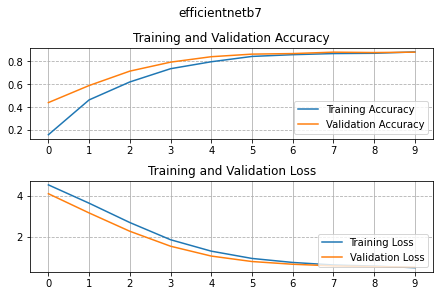

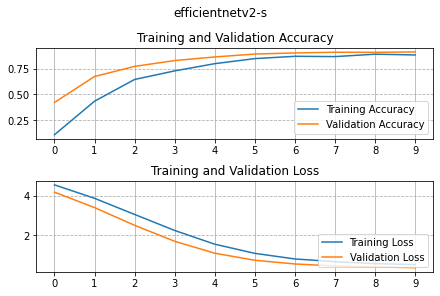

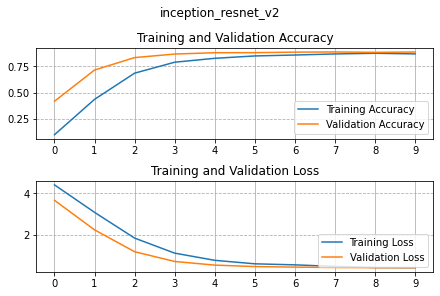

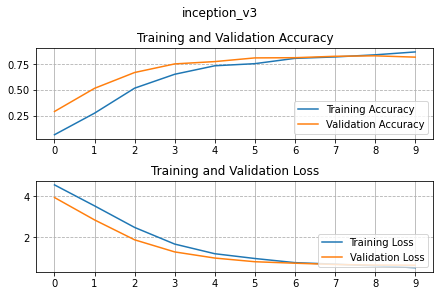

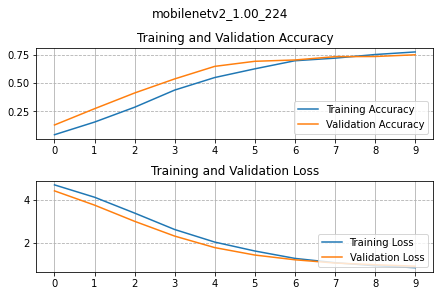

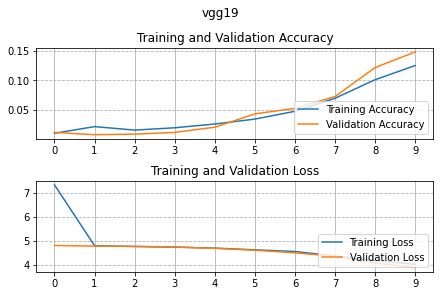

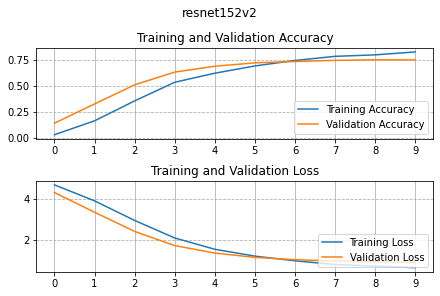

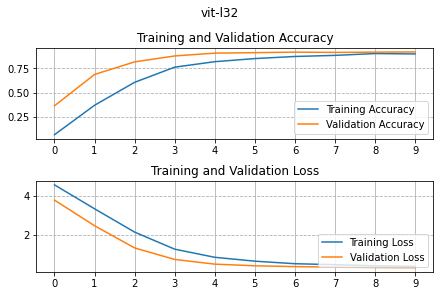

In [ ]:
# allows us to check for overfitting
for key, value in histories.items():
  history, time_taken = value
  plot_learning_curves(key, time_taken, history)

These graphs allow us to see which model is overfitting.

In [ ]:
def plot_validation_accuracy_curve(ax, name, history):
  val_acc = history.history['val_accuracy']
  epochs_range = range(len(val_acc))
  ax.plot(epochs_range, val_acc, label=f'{name}')

Visualization of overall data

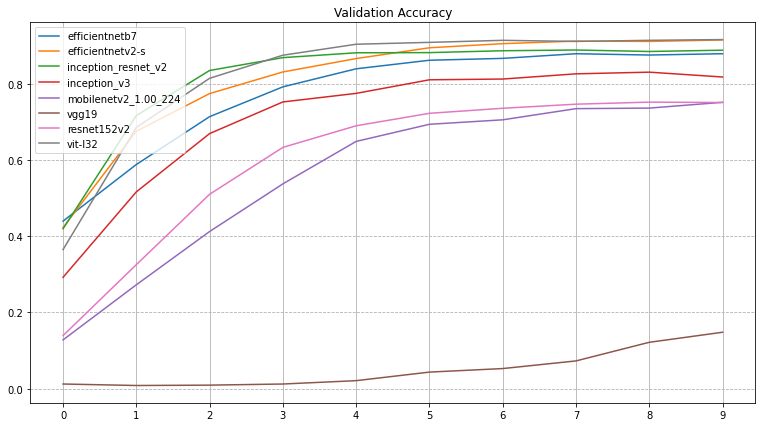

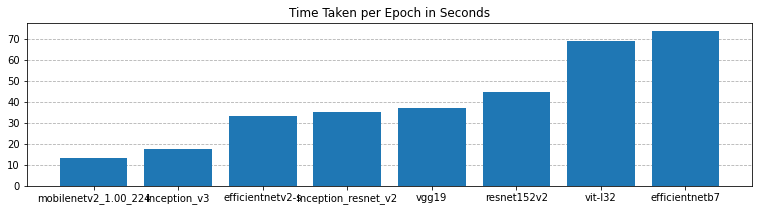

In [ ]:
time_taken_dict = {}

# validation accuracy
fig, ax = plt.subplots(figsize=(13, 7))
ax.xaxis.set_major_locator(mticker.MultipleLocator(1))
ax.yaxis.grid(linestyle='--')
ax.xaxis.grid(linestyle='-')
ax.set_title(f'Validation Accuracy')

for key, value in histories.items():
  history, time_taken = value
  time_taken_dict[key] = time_taken / epochs

  plot_validation_accuracy_curve(ax, key, history)
ax.legend(loc='upper left')
fig.show()

# time taken
fig, ax = plt.subplots(figsize=(13, 3))
ax.set_title(f'Time Taken per Epoch in Seconds')
ax.yaxis.grid(linestyle='--')
ax.set_axisbelow(True)

lists = sorted(time_taken_dict.items(), key=lambda item: item[1]) # sorted by key, return a list of tuples
x, y = zip(*lists) # unpack a list of pairs into two tuples

ax.bar(x, y)
fig.show()

## Training Final Model

In [19]:
restart()
tf.random.set_seed(886)
np.random.seed(886)

# ds_train, ds_test = ds_both["train"], ds_both["test"]

epochs = 5

structure, preprocessing = [vit_keras.vit.vit_l32, vit_keras.vit.preprocess_inputs]
print("[EfficientNetV2S] Creating Datasets")
train_set, valid_set = create_datasets(preprocessing)
print("[EfficientNetV2S] Creating Model")
model, transfer_model = create_model(structure, True, False, True, vit_keras.vit.preprocess_inputs)
model_name = transfer_model.name
print(f"[{model_name}] Training Model")
histories[model_name] = train_model(model, model_name, epochs, True)
print(f"[{model_name}] ***** Finished *****")

[EfficientNetV2S] Creating Datasets
[EfficientNetV2S] Creating Model


[vit-l32] Training Model
Epoch 1/5


94/94 [==============================] - 713s 7s/step - loss: 4.5397 - accuracy: 0.0545 - val_loss: 2.6268 - val_accuracy: 0.5286
Epoch 2/5
94/94 [==============================] - 663s 7s/step - loss: 3.5792 - accuracy: 0.1899 - val_loss: 1.2099 - val_accuracy: 0.7660
Epoch 3/5
94/94 [==============================] - 665s 7s/step - loss: 3.1426 - accuracy: 0.2524 - val_loss: 0.8586 - val_accuracy: 0.8323
Epoch 4/5
94/94 [==============================] - 665s 7s/step - loss: 2.9906 - accuracy: 0.2790 - val_loss: 0.7458 - val_accuracy: 0.8408
Epoch 5/5
94/94 [==============================] - 668s 7s/step - loss: 2.8790 - accuracy: 0.2945 - val_loss: 0.6807 - val_accuracy: 0.8551
[vit-l32] ***** Finished *****


# Error analysis

Now that we have our final model, let's try to analyse the type of errors it makes.

Let's first plot the confusion matrix:

In [21]:
final_model = keras.models.load_model("vit-l32_model_no_augm.h5")

In [22]:
_, test_set = create_datasets(preprocessing)

def get_confusion_matrix(model, validation_generator):
    all_predictions = np.array([])
    all_labels = np.array([])
    for a in validation_generator:
        x_batch, y_batch = a
        predictions = model.predict(x_batch)
        predictions = np.argmax(predictions, axis = 1)
        all_predictions = np.concatenate([all_predictions, predictions])
        # labels = np.argmax(y_batch, axis = 1)
        all_labels = np.concatenate([all_labels, y_batch])

    return tf.math.confusion_matrix(all_predictions, all_labels)

cf_mx = get_confusion_matrix(final_model, test_set)
print(cf_mx)

1/1 [==============================] - 6s 6s/step
tf.Tensor(
[[ 41   0   0 ...   0   0   0]
 [  1  80   0 ...   0   0   0]
 [  0   0 149 ...   0   0   0]
 ...
 [  0   0   0 ...  45   3   0]
 [  0   0   0 ...   2  47   0]
 [  0   0   0 ...   1   0  69]], shape=(120, 120), dtype=int32)


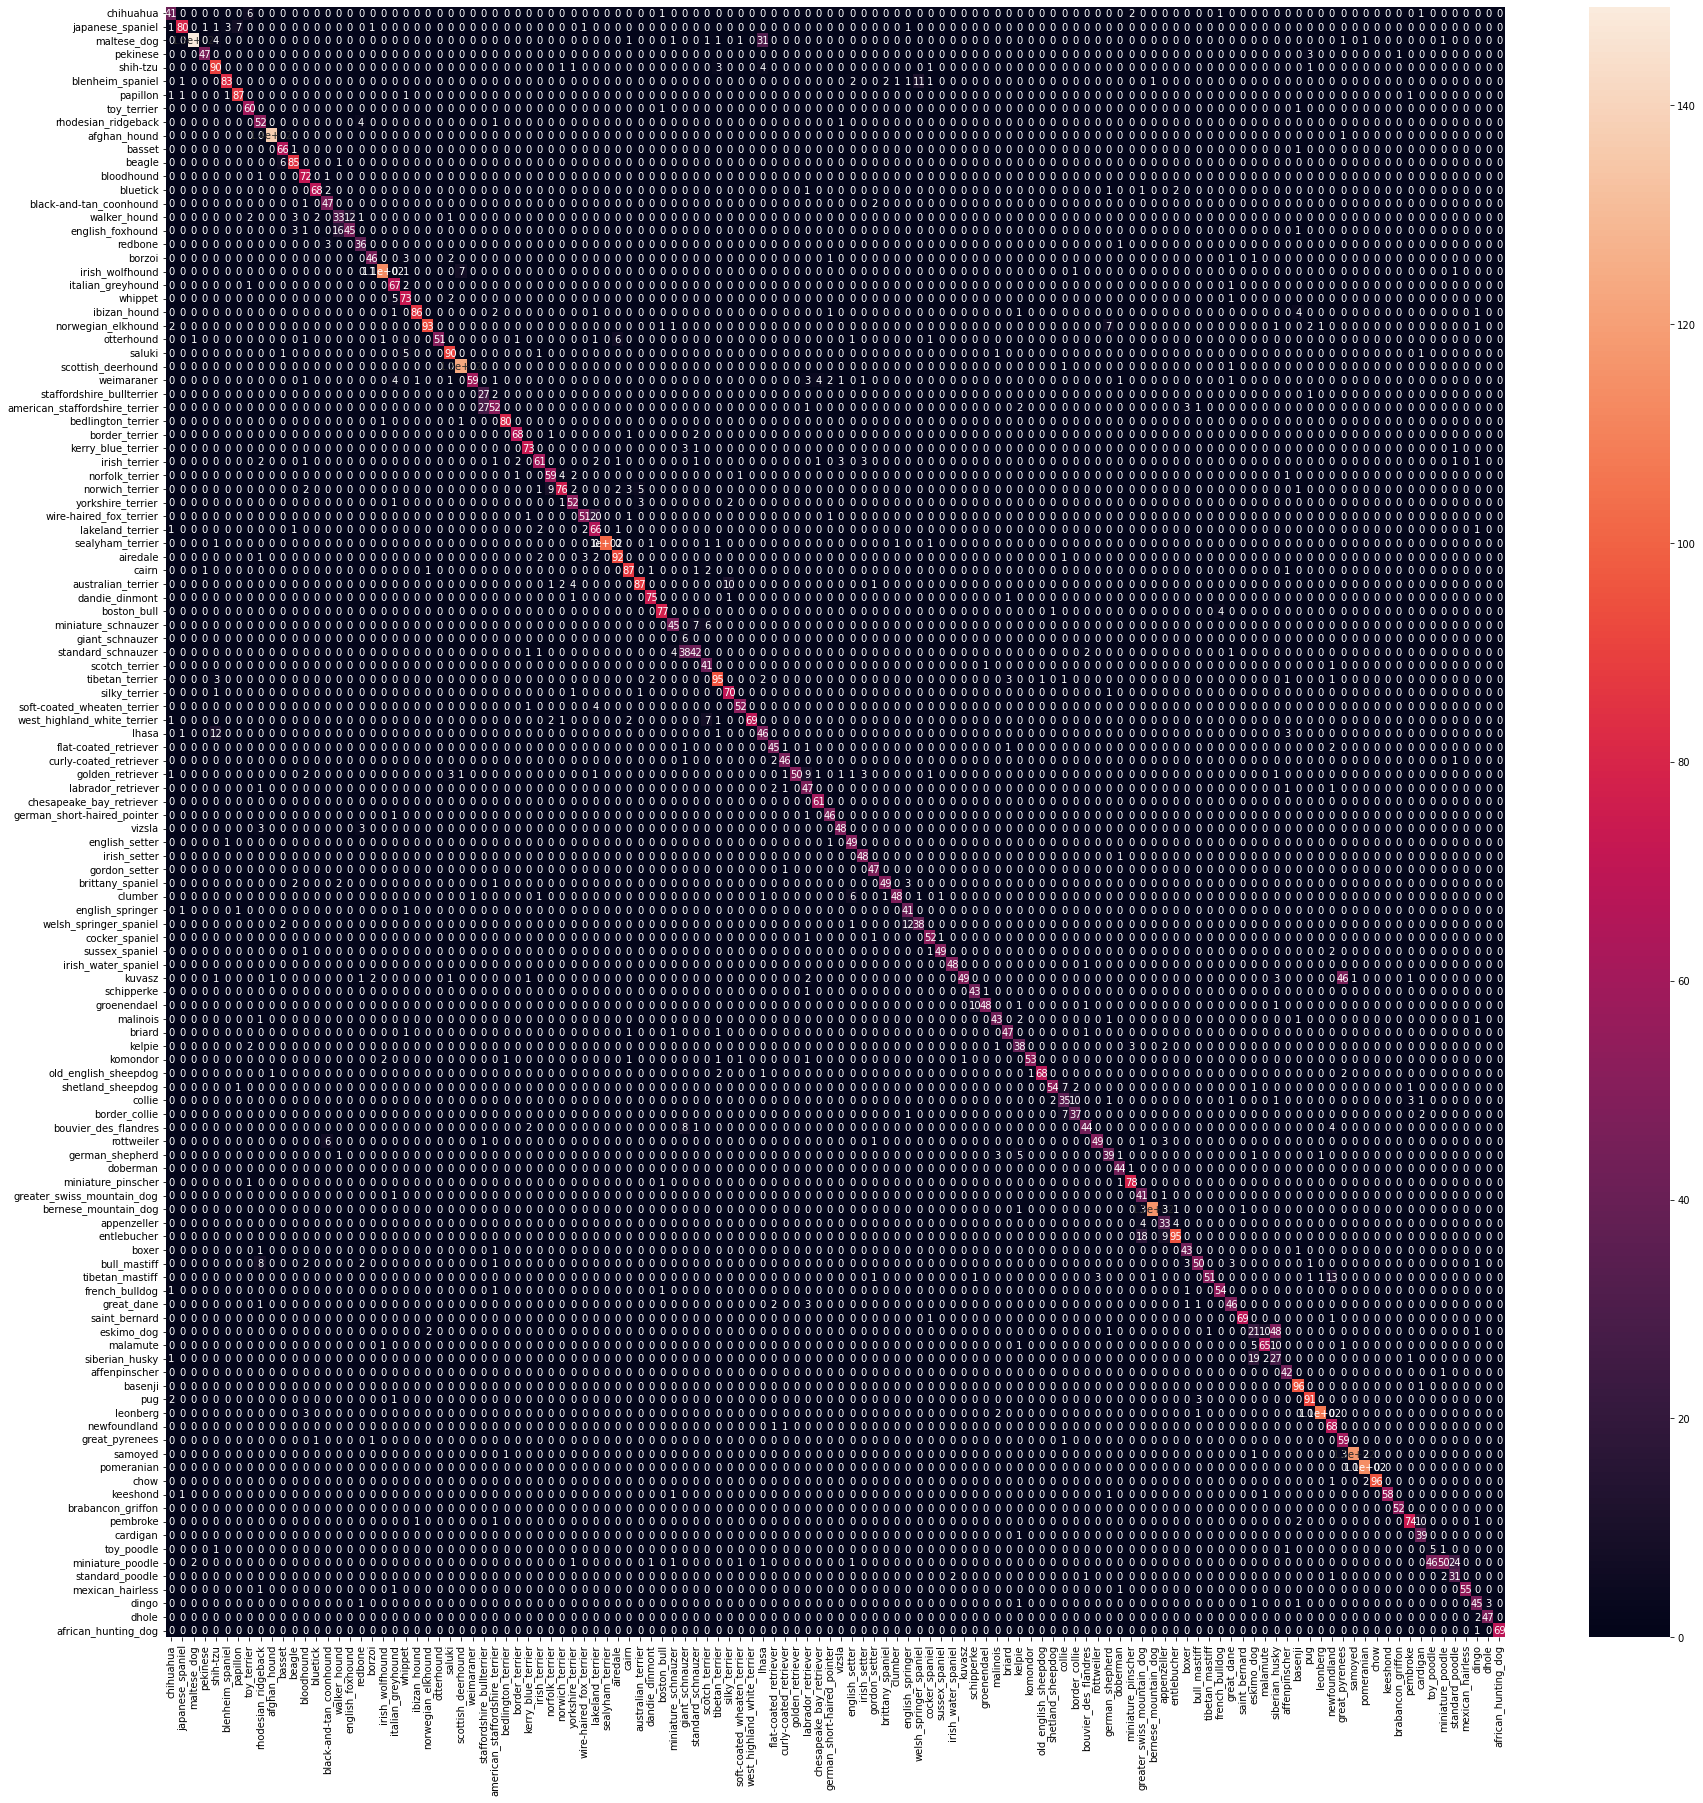

In [23]:
import seaborn as sn
import pandas as pd

class_names = [class_[10:] for class_ in class_names] 

df_cm = pd.DataFrame(cf_mx, index=[i for i in class_names],
                      columns=[i for i in class_names])
df_cm = df_cm.astype(int)

plt.figure(figsize=(30,30))
sn.heatmap(df_cm, annot=True)

In [24]:
print(class_names)

def plot_confused_classes(class_name):
    class_index = class_names.index(class_name)
    confusion_class = cf_mx[class_index] # shape (120,)
    classes = []
    freqencies = []
    for index, freq in enumerate(confusion_class):
        if freq != 0: # the model predict that the image belongs to this class
            classes.append(class_names[index])
            freqencies.append(freq)
    
    print(classes, freqencies)
    colors = ['g' if name == class_name else 'gray' for name in classes]
    plt.bar(classes, freqencies, color=colors)
    plt.xticks(rotation=75)
    plt.show()

['chihuahua', 'japanese_spaniel', 'maltese_dog', 'pekinese', 'shih-tzu', 'blenheim_spaniel', 'papillon', 'toy_terrier', 'rhodesian_ridgeback', 'afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'black-and-tan_coonhound', 'walker_hound', 'english_foxhound', 'redbone', 'borzoi', 'irish_wolfhound', 'italian_greyhound', 'whippet', 'ibizan_hound', 'norwegian_elkhound', 'otterhound', 'saluki', 'scottish_deerhound', 'weimaraner', 'staffordshire_bullterrier', 'american_staffordshire_terrier', 'bedlington_terrier', 'border_terrier', 'kerry_blue_terrier', 'irish_terrier', 'norfolk_terrier', 'norwich_terrier', 'yorkshire_terrier', 'wire-haired_fox_terrier', 'lakeland_terrier', 'sealyham_terrier', 'airedale', 'cairn', 'australian_terrier', 'dandie_dinmont', 'boston_bull', 'miniature_schnauzer', 'giant_schnauzer', 'standard_schnauzer', 'scotch_terrier', 'tibetan_terrier', 'silky_terrier', 'soft-coated_wheaten_terrier', 'west_highland_white_terrier', 'lhasa', 'flat-coated_retriever', 'cur

['norwegian_elkhound', 'german_shepherd', 'tibetan_mastiff', 'eskimo_dog', 'malamute', 'siberian_husky', 'dingo'] [<tf.Tensor: shape=(), dtype=int32, numpy=2>, <tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=21>, <tf.Tensor: shape=(), dtype=int32, numpy=10>, <tf.Tensor: shape=(), dtype=int32, numpy=48>, <tf.Tensor: shape=(), dtype=int32, numpy=1>]


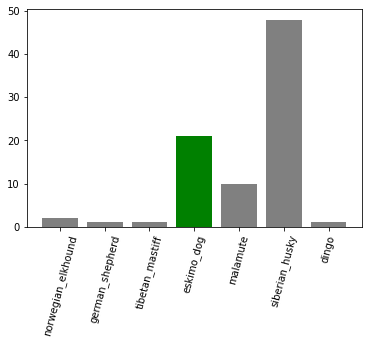

['chihuahua', 'eskimo_dog', 'malamute', 'siberian_husky', 'pembroke'] [<tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=19>, <tf.Tensor: shape=(), dtype=int32, numpy=2>, <tf.Tensor: shape=(), dtype=int32, numpy=27>, <tf.Tensor: shape=(), dtype=int32, numpy=1>]


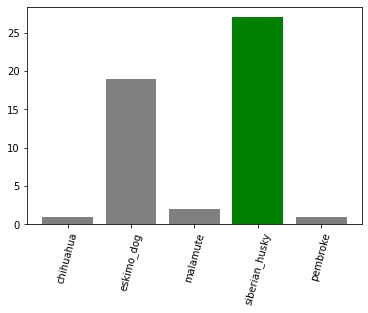

['maltese_dog', 'yorkshire_terrier', 'dandie_dinmont', 'miniature_schnauzer', 'soft-coated_wheaten_terrier', 'lhasa', 'english_setter', 'toy_poodle', 'miniature_poodle', 'standard_poodle'] [<tf.Tensor: shape=(), dtype=int32, numpy=2>, <tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=46>, <tf.Tensor: shape=(), dtype=int32, numpy=50>, <tf.Tensor: shape=(), dtype=int32, numpy=24>]


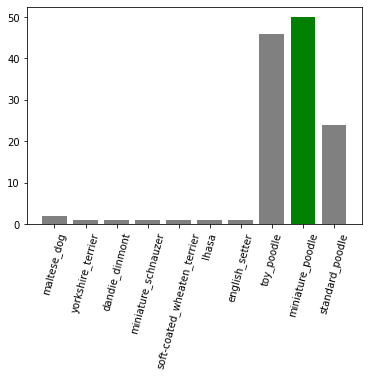

['beagle', 'bloodhound', 'walker_hound', 'english_foxhound', 'basenji'] [<tf.Tensor: shape=(), dtype=int32, numpy=3>, <tf.Tensor: shape=(), dtype=int32, numpy=1>, <tf.Tensor: shape=(), dtype=int32, numpy=16>, <tf.Tensor: shape=(), dtype=int32, numpy=45>, <tf.Tensor: shape=(), dtype=int32, numpy=1>]


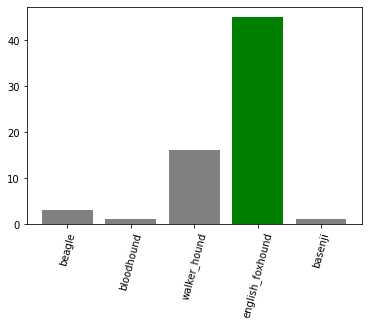

In [25]:
plot_confused_classes('eskimo_dog')
plot_confused_classes('siberian_husky')
plot_confused_classes('miniature_poodle')
plot_confused_classes('english_foxhound')